<a href="https://colab.research.google.com/github/dtabuena/EphysLib/blob/main/Synapse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'Get Standard Modules'

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import os
from scipy.signal import butter,filtfilt
from tqdm import tqdm
import warnings
from IPython.display import clear_output
from datetime import datetime
import sys
import warnings
import shutil
from google.colab import files
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)
clear_output(wait=False)



!pip install openpyxl
!pip install XlsxWriter


'''Get Repositories'''
try: shutil.rmtree('/content/EphysLib')
except: None

"run dtabuena's ephys notebooks"
!git clone https://github.com/dtabuena/EphysLib
to_import = [
            'ABF_Quality_Control.ipynb',
            'Basic_Ephys.ipynb',
            'Simple_ABF_tools.ipynb',
            'fun_math.ipynb',
            'importing_abfs_from_dropbox.ipynb',
            'QC_recoding_dataframe.ipynb',
            'Analyzers/input_resistance_analyzer.ipynb',
            'Analyzers/gain_analyzer.ipynb',
            'Analyzers/latencey_analyzer.ipynb',
            'Analyzers/IV_analyzer.ipynb',
            'Analyzers/Vm_analyzer.ipynb',
            'Analyzers/membrane_analyzer.ipynb',
            'Analyzers/rheobase_analyzer.ipynb',
            'Ephys_wrapper.ipynb',
            ]
for i in to_import:
    f = '/content/EphysLib/' + i
    %run $f




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 2.2 MB/s eta 0:00:00
Cloning into 'EphysLib'...
remote: Enumerating objects: 1037, done.
remote: Counting objects: 100% (414/414), done.
remote: Compressing objects: 100% (221/221), done.
remote: Total 1037 (delta 309), reused 230 (delta 193), pack-reused 623
Receiving objects: 100% (1037/1037), 14.67 MiB | 13.46 MiB/s, done.
Resolving deltas: 100% (686/686), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 2.4 MB/s eta 0:00:00


In [2]:
##### Setup Protocol List
VC_prot = ['VC - MemTest-10ms-160ms',
           'VC - Multi IV - 150ms',]
IC_prot = ['IC - Gain - D20pA',
           'IC - Gain - D50pA',
           'IC - Rheobase',
           'IC - R input',
           'IC - Latentcy 800pA-1s'
           'VC - 3min GapFree',
           'I0 - 3min GapFree']

In [3]:
dataset = {'data_name': 'Today',
           'data_source': "https://www.dropbox.com/sh/wnbpd76u1v28qnz/AADD0BDu0BF81SAlN4Q6QxFea?dl=0",
           'file_naming_scheme': ['Rec_date','GenoType','Sex','Age','Slice_Num','Cell_num','Cell_Type'],
           }
           
data_name = dataset['data_name']
data_source = dataset['data_source']
file_naming_scheme = dataset['file_naming_scheme']

''' Gather and Catalog Source Data'''
file_loc = get_drobox_folder(data_source, 'my_ephys_data_' + data_name)
clear_output(wait=False)   
abf_recordings_df, protocol_set = catalogue_recs(file_loc,file_naming_scheme)
print(protocol_set)

['IC - R input', 'VC - Multi IV - 150ms', 'IC - Latentcy 800pA-1s', 'VC - MemTest-10ms-160ms', 'IC - Rheobase', 'VC - 3min GapFree', 'IC - Gain - D10pA', 'VC - 70mV - 3min GapFree', 'VC - Multi IV - 450ms', 'I0 - 3min GapFree']


In [4]:

display(abf_recordings_df.columns)

Index(['Recording_name', 'cell_id', 'Rec_date', 'GenoType', 'Sex', 'Age',
       'Slice_Num', 'Cell_num', 'Cell_Type', 'protocol', 'abf_timestamp',
       'channelList'],
      dtype='object')

In [5]:
synapse = ['VC - 70mV - 3min GapFree', 'VC - 3min GapFree']
for r in abf_recordings_df.index:
    if abf_recordings_df.loc[r,'protocol'] in synapse:
        print(r)

my_ephys_data_Today/2023x04x12_E4KI_F_P236_s001_c001_DG_0004.abf
my_ephys_data_Today/2023x04x12_E4KI_F_P236_s001_c001_DG_0007.abf
my_ephys_data_Today/2023x04x12_E4KI_F_P236_s001_c001_DG_0008.abf
my_ephys_data_Today/2023x04x12_E4KI_F_P236_s001_c002_DG_0003.abf
my_ephys_data_Today/2023x04x12_E4KI_F_P236_s001_c002_DG_0004.abf
my_ephys_data_Today/2023x04x12_E4KI_F_P236_s001_c002_DG_0011.abf
my_ephys_data_Today/2023x04x12_E4KI_F_P236_s001_c003_DG_0003.abf
my_ephys_data_Today/2023x04x12_E4KI_F_P236_s001_c003_DG_0009.abf
my_ephys_data_Today/2023x04x12_E4KI_F_P236_s002_c004_DG_0007.abf
my_ephys_data_Today/2023x04x12_E4KI_F_P236_s002_c005_DG_0009.abf
my_ephys_data_Today/2023x04x12_E4KI_F_P236_s003_c006_DG_0009.abf
my_ephys_data_Today/2023x04x12_E4KI_F_P236_s003_c006_DG_0010.abf
my_ephys_data_Today/2023x04x12_E4KI_F_P236_s003_c006_DG_0011.abf
my_ephys_data_Today/2023x04x12_E4KI_F_P236_s003_c007_DG_0007.abf
my_ephys_data_Today/2023x04x12_E4KI_F_P236_s003_c007_DG_0008.abf
my_ephys_data_Today/2023x

In [6]:
# 
# Fast_results = ephys_wrapper(dataset,VC_prot,IC_prot,strat_cols=[ 'Cell_Type'])

In [7]:
# strat_abfs_by_prot( 'reorg','/content/my_ephys_data_'+dataset['data_name'], f"/content/{dataset['data_name']}_Recording_LookUp.csv" )

In [8]:
# single_val_strat_groups = ['ap_amplitutude',
#                             'Rmp_mV',
#                             'Ra_160.0',
#                             'Rm_160.0',
#                             'Cm_pc_10.0',                    
#                             'Cmq_160.0',
#                             'Ra_160.0',
#                             'Rm_160.0',
#                             'Gain_(HzpA)',
#                             'max_adapt%',
#                             'adapt_thresh_90',                            
#                             'Rheobase',
#                             'AP_thresh_US',
#                             'fast_after_hyperpol',
#                             'Spike_latency_(ms)',
#                             'Input_Resistance_MO',
#                             ]


# manual_exclusions = [''] # Dramatic shift in seal at unknown time during recording.
# exclusion_overide = [''] # Vm dramatically improved prior to gain recording


# strat_df_dict = Fast_results['strat_df_dict'].copy()
# file_naming_scheme = ['Rec_date', 'GenoType', 'Sex', 'Age', 'Slice_Num', 'Cell_num', 'Cell_Type']
# filtered_dict, fail_dict = final_qc(strat_df_dict,file_naming_scheme,qc_Rmp=-45,qc_AP_amp=40,qc_RR=.35,qc_Ra=65,manual_exclusions=manual_exclusions,exclusion_overide=exclusion_overide)
# alt_strat_dict = restratify_results(filtered_dict,file_naming_scheme,single_val_strat_groups)
# resp_curve_list = ['IV_Early_(V_stim)','IV_Early_(I_peak)','IV_Steady_State_(I_mean)','Stim_Levels_(pA)','Spike_Counts']
# response_curve_data = stratify_response_curve(filtered_dict,resp_curve_list,strat_list=[''])
# alt_strat_dict.update(response_curve_data)

# write_strat_dfs(alt_strat_dict, dataset['data_name']+'_results_stratified_alternate')

4sd: 7.465865282795103
(115, 250)


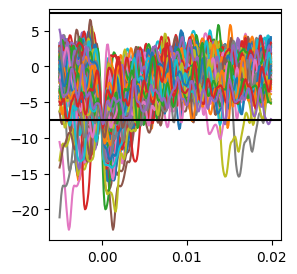

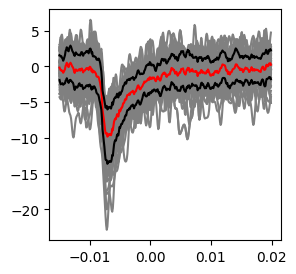

In [104]:
import scipy as sc




def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = np.min([1-1/fs,highcut / nyq])
    b, a = sc.signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):

    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    data = sc.signal.filtfilt(b, a, data)

    b_notch,a_notch = sc.signal.iirnotch(50, 20, fs=fs)
    data = sc.signal.filtfilt(a_notch, a_notch, data)
    data = data-np.mean(data)
    return data

def filter_for_PSCs(abf, lowcut, highcut,):
    time = abf.sweepX
    response = abf.sweepY
    holding = abf.sweepC
    fs=abf.sampleRate
    response_f1 = butter_bandpass_filter(response, lowcut, highcut, fs  ) 
    response_f2 = butter_bandpass_filter(response, .01, 5000, fs  )
    
    # fig,ax = plt.subplots(1,figsize=[16,3])
    # ax.plot(time,response_f2,'k')
    # ax.plot(time,response_f1,'r')
    x0 = np.random.choice(time,1)
    x0 = 25.25
    dur = 3
    xlims = x0 +np.array([0,dur])
    ax.set_xlim(xlims)
    ax.set_ylim([-30,10])

    return response_f1

def find_events(response_f1,fs, sd_thresh = 5,cool_down_time=0,to_plot= True):
    sd = np.std(response_f1)
    print(str(sd_thresh)+'sd:',sd*sd_thresh)
    cool_down_idx = cool_down_time*fs
    is_event_up = response_f1 < sd*-sd_thresh
    # is_event = abs(response_f1)>sd*sd_thresh
    is_event = is_event_up
    event_start = np.diff(is_event,prepend=0)>0
    starts = np.where(event_start)[0]

    x0t = -.005
    x1t = 0.02
    x0n = x0t*fs
    x1n = x1t*fs

    fig,ax = plt.subplots(1,figsize=[3,3])
    time_wind = np.arange(x0t,x1t,1/fs)
    stack = []
    for e in starts:    
        indx_wind = e + np.arange(x0n,x1n,dtype=int)
        try:
            resp_wind = response_f1[indx_wind]
            ax.plot(time_wind,resp_wind)
            stack.append(resp_wind)
        except: None
        
    ax.axhline(sd*sd_thresh,color='k')
    ax.axhline(-sd*sd_thresh,color='k')
    stack_np = np.stack(stack,axis=0)
    print(stack_np.shape)

    return stack_np


def make_template(stack_np):
    U, s, Vh = sc.linalg.svd(stack_np,full_matrices=False)
    u, s, vh = sc.sparse.linalg.svds(stack_np,k=1)
    stack_reduced = u @ np.diag(s) @ vh
    template = vh.T.flatten()
    # fig,ax = plt.subplots()
    # ax.plot(template)
    return template, template/np.sum(template)


def search_for_template(trace, template,corr_thresh=3,window=[-0.015,0.02]):
    fig,ax = plt.subplots(1,figsize=[3,3])
    corr = np.correlate(trace , template, mode='same')
    is_corr_event = corr>corr_thresh
    is_corr_event = np.diff(is_corr_event,prepend=0)>0
    event_inds = np.where(is_corr_event)[0]
    time_wind = np.arange(window[0],window[1],1/fs)    
    corr_stack =  window_stack(corr,[window[0]*fs,window[1]*fs],event_inds)
    max_corr = np.max(corr_stack,axis=1)
    for r in range(len(max_corr)):
        shift = np.where(corr_stack[r,:] == max_corr[r] )[0][0]
        event_inds[r] = event_inds[r] + (shift + window[0]*fs) 
        
    

    stack = window_stack(trace,[window[0]*fs,window[1]*fs],event_inds)
    epsc_mean = np.median(stack,axis=0)
    epsc_std = np.std(stack,axis=0)
    ax.plot(time_wind,stack.T,'grey')
    ax.plot(time_wind,epsc_mean,color='red')
    ax.plot(time_wind,epsc_mean+epsc_std,color='k')
    ax.plot(time_wind,epsc_mean-epsc_std,color='k')
    plt.show()
    return {'stack':stack, 'epsc_mean':epsc_mean, 'epsc_std':epsc_std}


def window_stack(trace,ind_range,inds):
    window = np.arange(ind_range[0],ind_range[1],dtype='int')
    stack = []
    for i in inds:
        indx_wind = i + window
        
        try:
            i_trace = trace[indx_wind]
            # ax.plot(window,i_trace,'grey')
            stack.append(i_trace)
        except: None    
    stack = np.stack(stack)
    return stack


to_plot= True
abf=abf_or_name('my_ephys_data_Today/2023x04x12_E4KI_F_P236_s001_c001_DG_0007.abf')


time = abf.sweepX
response = abf.sweepY
holding = abf.sweepC
fs=abf.sampleRate





response_f1 = filter_for_PSCs(abf, lowcut = .5, highcut = 1000)
stack_np = find_events(response_f1,fs, sd_thresh = 4,cool_down_time = 0.005 , to_plot= True)
_,template = make_template(stack_np)
res = search_for_template(response_f1, -template, corr_thresh=3)

